<a href="https://colab.research.google.com/github/Mostafa-MMK/VaRBacktestingEngine/blob/main/0_historical_var_es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Packages

In [20]:
# Installing Packages
!pip install yfinance scienceplots --quiet
!apt-get update -qq
!apt-get install -y texlive-latex-extra texlive-fonts-recommended dvipng cm-super --quiet


# For latex text in the graphs
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists...
Building dependency tree...
Reading state information...
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-latex-extra is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


# Main Functions (OOP)

In [21]:
import yfinance as yf
import numpy as np
import pandas as pd
import scienceplots
import matplotlib.pyplot as plt
from scipy.stats import norm

In [22]:
class RiskEngine:
    def __init__(self, tickers, df_returns = None):
        self.tickers = tickers
        self.df_returns = df_returns

    # Getting and Wrangling Data
    def data_preparation(self):
        data = yf.download(self.tickers, start= '2000-01-01', auto_adjust=True)['Close'].dropna()
        data.columns = self.tickers
        df_returns = np.log(data/data.shift(1)).dropna()
        self.df_returns = df_returns
        return df_returns


    # Variance Covariance Method
    def VC_VaR_ES(self):

        confidences = np.arange(0.90, 1.0, 0.01)
        mu = self.df_returns.mean()
        sigma = self.df_returns.std()
        np.random.seed(121)

        vc_results = []
        for conf in confidences:
            z = norm.ppf(conf)
            phi_z = norm.pdf(z)
            for tick in self.tickers:
                vars_ = mu[tick] - (sigma[tick] * z)
                exp_terms = (np.exp(-0.50 * z ** 2)) / ((1 - conf) * np.sqrt(2 * np.pi))
                es_ = mu[tick] - (sigma[tick] * exp_terms)
                vc_results.append({'Confidence':conf,  'Ticker':tick, 'Method':'VC', 'VaR':vars_, 'ES':es_})
        vc_results = pd.DataFrame(vc_results)
        vc_results.set_index('Confidence', inplace = True)
        return vc_results

    # Historical Simulated VaR and ES
    def Hist_VaR_ES(self):
        confidences = np.arange(0.90, 1.0, 0.01)
        sorted_returns = self.df_returns.apply(np.sort)
        hist_results = []

        for conf in confidences:
            for tick in self.tickers:
                vars_ = np.quantile(sorted_returns[tick], (1 - conf))
                es_ = sorted_returns[tick][sorted_returns[tick] <= vars_].mean()
                hist_results.append({'Confidence': conf, 'Ticker': tick, 'Method':'HS', 'VaR': vars_, 'ES': es_})
        hist_results = pd.DataFrame(hist_results)
        hist_results.set_index('Confidence', inplace = True)
        return hist_results

    # Bootstrapped Simulated VaR and ES
    def BootStrapped_HS_VaR_ES(self):
        rng = np.random.default_rng(100)
        confidences = np.arange(0.90, 1.0, 0.01)
        num_simulation = 10000
        simulated_returns = rng.choice(self.df_returns.values, size = num_simulation, replace = True)
        sorted_returns = (pd.DataFrame(simulated_returns, columns = self.df_returns.columns)).apply(np.sort)

        boot_results = []
        for conf in confidences:
            for tick in self.tickers:
                vars_ = np.quantile(sorted_returns[tick], (1 - conf))
                es_ = sorted_returns[tick][sorted_returns[tick]<= vars_].mean()
                boot_results.append({'Confidence': conf, 'Ticker':tick, 'Method': 'BTS', 'VaR':vars_, 'ES':es_})

        boot_results = pd.DataFrame(boot_results)
        boot_results.set_index('Confidence', inplace = True)
        return boot_results

    # Monte-Carlo Simulated VaR and ES
    def Monte_Carlo_VaR_ES(self):
        rng = np.random.default_rng(10)
        num_simulation = 10000
        confidences = np.arange(0.90, 1.0, 0.01)

        mu = self.df_returns.mean()
        sigma = self.df_returns.std()

        sample_returns = rng.normal(loc = mu, scale = sigma, size = (num_simulation, len(self.df_returns.columns)))
        sorted_returns = (pd.DataFrame(sample_returns, columns = self.df_returns.columns)).apply(np.sort)
        mc_results = []

        for conf in confidences:
            for tick in self.tickers:
                vars_ = np.quantile(sorted_returns[tick], (1 - conf))
                es_ = sorted_returns[tick][sorted_returns[tick] <= vars_].mean()
                mc_results.append({'Confidence': conf, 'Ticker': tick, 'Method': 'MC', 'VaR': vars_, 'ES': es_})
        mc_results = pd.DataFrame(mc_results)
        mc_results.set_index('Confidence', inplace = True)
        return mc_results

# Executions

In [23]:
# Results
tickers = ['AAPL', 'TSLA', 'GOOG', 'MSFT']
framework = RiskEngine(tickers)
df_returns = framework.data_preparation()
vc_results = framework.VC_VaR_ES()
hist_results = framework.Hist_VaR_ES()
boot_results = framework.BootStrapped_HS_VaR_ES()
mc_results = framework.Monte_Carlo_VaR_ES()

[*********************100%***********************]  4 of 4 completed


# Plotting Results

## Variance Covariance Method

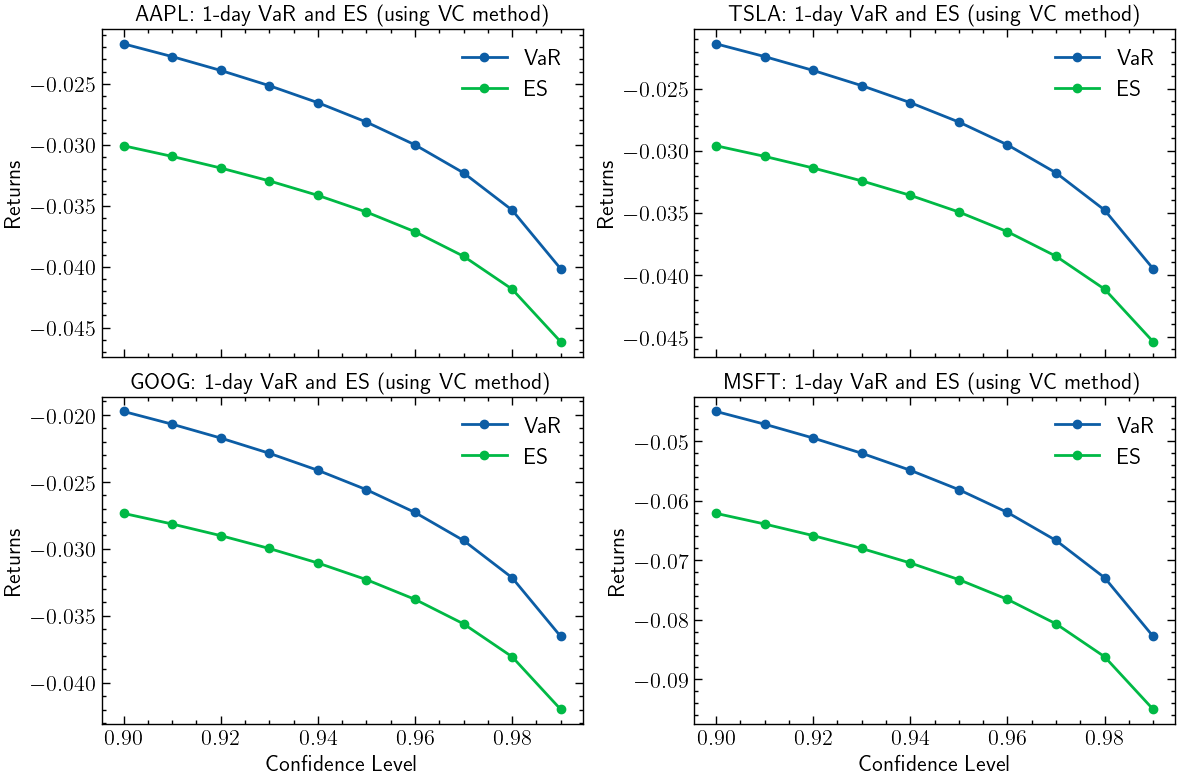

In [24]:
# Creating plots for each asset

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8), sharex = True, sharey = False)
axes = axes.flatten()

for tick, ax in zip(tickers, axes):
  vc_results[vc_results.Ticker == tick].plot(ax = ax, marker = 'o')
  ax.set_title(f"{tick}: 1-day VaR and ES (using VC method)" )
  ax.set_xlabel('Confidence Level')
  ax.set_ylabel('Returns')
  ax.legend(loc = 'best', frameon = False)
  ax.grid(False)

plt.tight_layout()
plt.show()

## Historical Simulated Method

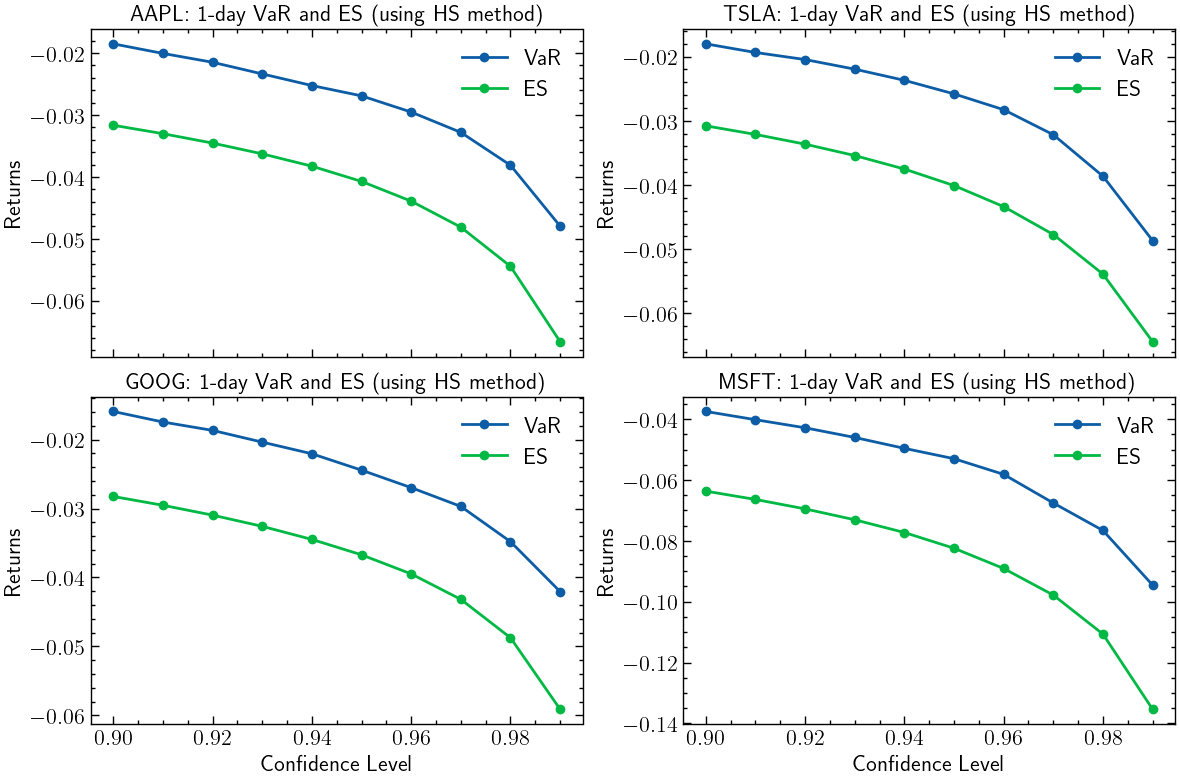

In [25]:
# Creating plots for each asset

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8), sharex = True, sharey = False)
axes = axes.flatten()

for tick, ax in zip(tickers, axes):
  hist_results[hist_results.Ticker == tick].plot(ax = ax, marker = 'o')
  ax.set_title(f"{tick}: 1-day VaR and ES (using HS method)" )
  ax.set_xlabel('Confidence Level')
  ax.set_ylabel('Returns')
  ax.legend(loc = 'best', frameon = False)
  ax.grid(False)
plt.tight_layout()
plt.show()

## Bootstrapping Simulated Method

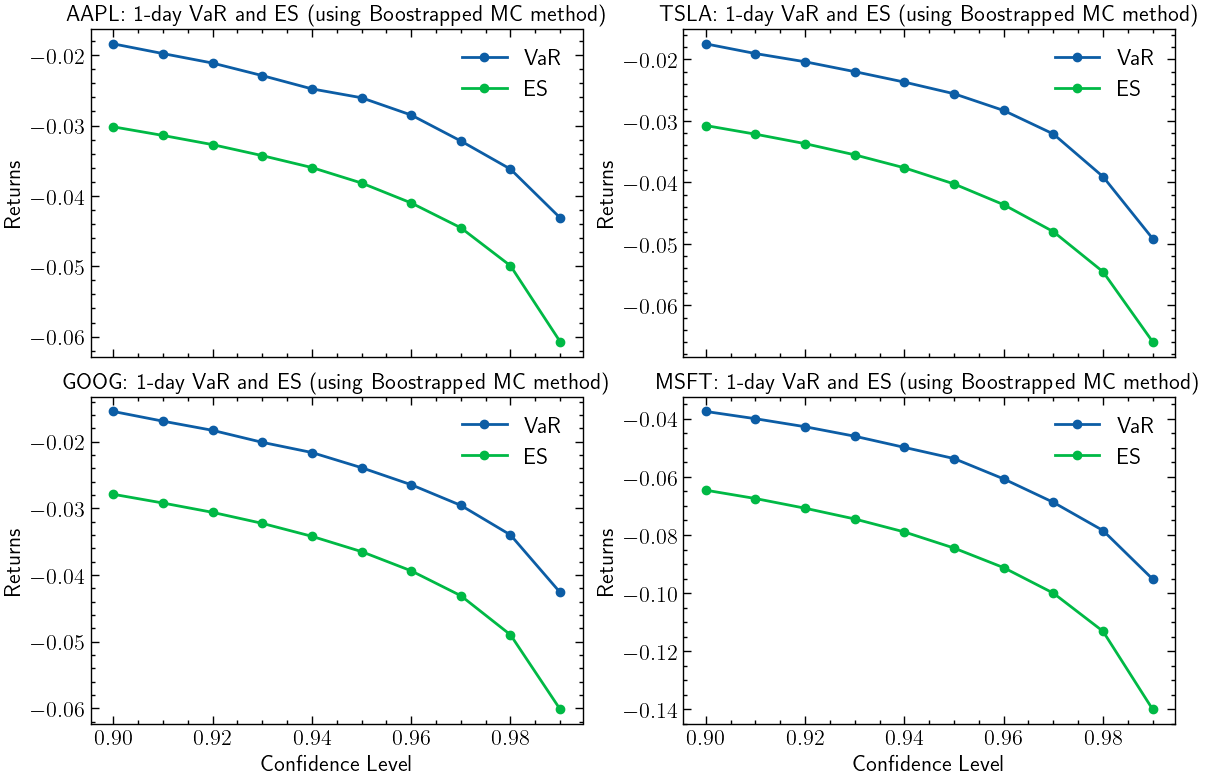

In [26]:
# Creating plots for each asset

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8), sharex = True, sharey = False)
axes = axes.flatten()

for tick, ax in zip(tickers, axes):
  boot_results[boot_results.Ticker == tick].plot(ax = ax, marker = 'o')
  ax.set_title(f"{tick}: 1-day VaR and ES (using Boostrapped MC method)")
  ax.set_xlabel('Confidence Level')
  ax.set_ylabel('Returns')
  ax.legend(loc = 'best', frameon = False)
  ax.grid(False)
plt.tight_layout()
plt.show()

## Monte Carlo Simulation Method

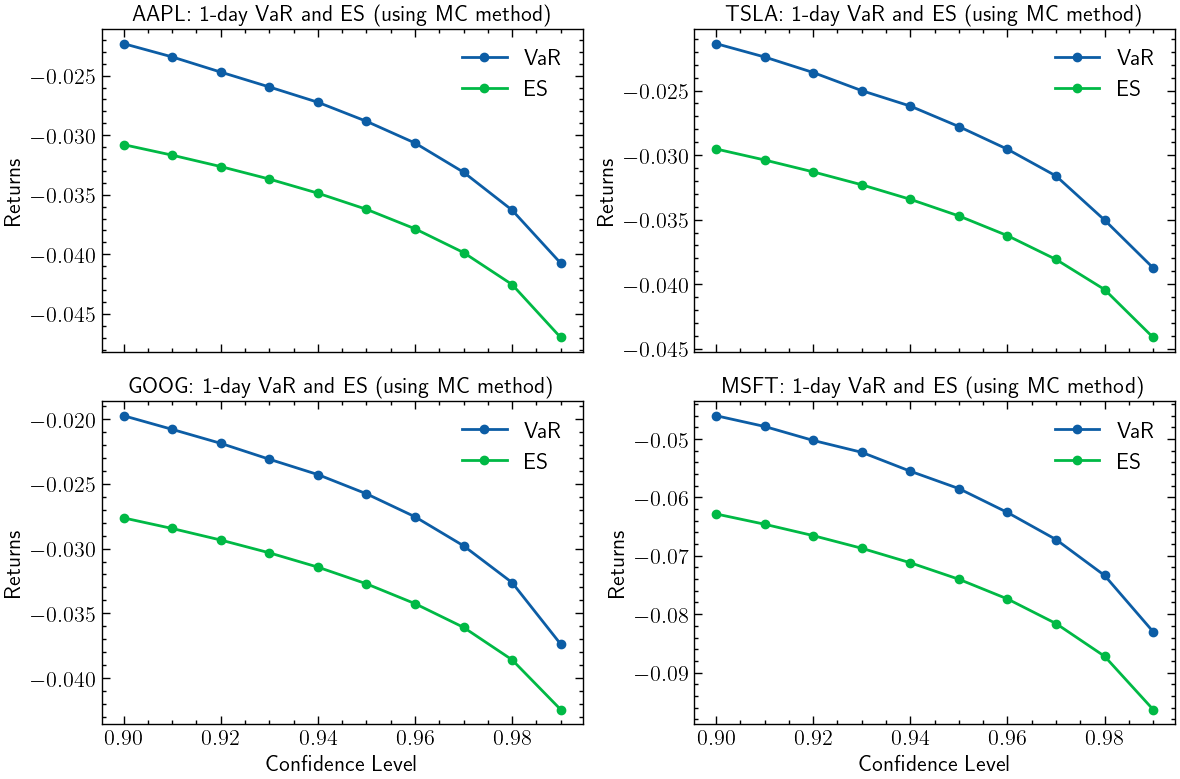

In [27]:
# Creating plots for each asset

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8), sharex = True, sharey = False)
axes = axes.flatten()

for tick, ax in zip(tickers, axes):
  mc_results[mc_results.Ticker == tick].plot(ax = ax, marker = 'o')
  ax.set_title(f"{tick}: 1-day VaR and ES (using MC method)" )
  ax.set_xlabel('Confidence Level')
  ax.set_ylabel('Returns')
  ax.legend(loc = 'best', frameon = False)
  ax.grid(False)
plt.tight_layout()
plt.show()

In [28]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class Backtesting_Framework:
    def __init__(self, tickers, window=252, confidence=0.99, df_returns=None):
        self.tickers = tickers
        self.window = window
        self.confidence = confidence
        self.df_returns = df_returns
        self.results = None

    def data_preparation(self):
        """Download and prepare return data"""
        df = yf.download(self.tickers, start='2020-01-01', auto_adjust=True)['Close'].dropna()
        df_returns = (np.log(df / df.shift(1))).dropna()
        self.df_returns = df_returns
        return df_returns

    def HS_Rolling_VaR_ES(self):
        """Calculate Historical Simulation VaR and Expected Shortfall"""
        if self.df_returns is None:
            raise ValueError("Please run data_preparation() first or provide df_returns")

        results = []

        for ticker in self.tickers:
            if ticker not in self.df_returns.columns:
                print(f"Warning: {ticker} not found in returns data")
                continue

            returns = self.df_returns[ticker]

            # Calculate rolling VaR (Historical Simulation method)
            rolling_var = returns.rolling(window=self.window).quantile(1 - self.confidence)

            # Calculate rolling ES (Expected Shortfall)
            rolling_es = returns.rolling(window=self.window).apply(
                lambda x: x[x <= x.quantile(1 - self.confidence)].mean()
            )

            # Get the most recent values
            recent_var = rolling_var.iloc[-1] if not rolling_var.empty else np.nan
            recent_es = rolling_es.iloc[-1] if not rolling_es.empty else np.nan

            results.append({
                'Ticker': ticker,
                'VaR': recent_var,
                'ES': recent_es,
                'VaR_Series': rolling_var,
                'ES_Series': rolling_es,
                'Returns': returns
            })

        self.results = pd.DataFrame(results)
        return self.results

    def plot_risk_metrics(self, ticker=None, figsize=(15, 10)):
        """Plot returns with VaR and ES for one or all tickers"""
        if self.results is None:
            raise ValueError("Please run HS_Rolling_VaR_ES() first")

        if ticker:
            # Plot for specific ticker
            ticker_data = self.results[self.results['Ticker'] == ticker].iloc[0]

            fig, axes = plt.subplots(2, 2, figsize=figsize)
            fig.suptitle(f'Risk Metrics for {ticker}', fontsize=16, fontweight='bold')

            # Plot 1: Returns with VaR and ES
            ax1 = axes[0, 0]
            ax1.plot(ticker_data['Returns'].index, ticker_data['Returns'],
                    label='Daily Returns', alpha=0.7, linewidth=0.5)
            ax1.plot(ticker_data['VaR_Series'].index, ticker_data['VaR_Series'],
                    label=f'VaR (99%)', color='red', linewidth=1.5)
            ax1.plot(ticker_data['ES_Series'].index, ticker_data['ES_Series'],
                    label='Expected Shortfall', color='darkred', linewidth=1.5, linestyle='--')
            ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            ax1.set_title(f'{ticker} Returns with Risk Metrics')
            ax1.set_ylabel('Returns')
            ax1.legend()
            ax1.grid(True, alpha=0.3)

            # Plot 2: Histogram of returns with VaR line
            ax2 = axes[0, 1]
            returns_data = ticker_data['Returns'].dropna()
            ax2.hist(returns_data, bins=50, alpha=0.7, edgecolor='black', density=True)
            ax2.axvline(x=ticker_data['VaR'], color='red', linewidth=2,
                       label=f'VaR = {ticker_data["VaR"]:.4f}')
            ax2.axvline(x=ticker_data['ES'], color='darkred', linewidth=2, linestyle='--',
                       label=f'ES = {ticker_data["ES"]:.4f}')
            ax2.set_title(f'Distribution of {ticker} Returns')
            ax2.set_xlabel('Returns')
            ax2.set_ylabel('Density')
            ax2.legend()
            ax2.grid(True, alpha=0.3)

            # Plot 3: VaR over time
            ax3 = axes[1, 0]
            ax3.plot(ticker_data['VaR_Series'].index, ticker_data['VaR_Series'],
                    label='VaR', color='red', linewidth=1.5)
            ax3.fill_between(ticker_data['VaR_Series'].index, ticker_data['VaR_Series'],
                            alpha=0.3, color='red')
            ax3.set_title(f'{ticker} VaR Over Time')
            ax3.set_xlabel('Date')
            ax3.set_ylabel('VaR')
            ax3.grid(True, alpha=0.3)

            # Plot 4: ES over time
            ax4 = axes[1, 1]
            ax4.plot(ticker_data['ES_Series'].index, ticker_data['ES_Series'],
                    label='Expected Shortfall', color='darkred', linewidth=1.5)
            ax4.fill_between(ticker_data['ES_Series'].index, ticker_data['ES_Series'],
                            alpha=0.3, color='darkred')
            ax4.set_title(f'{ticker} Expected Shortfall Over Time')
            ax4.set_xlabel('Date')
            ax4.set_ylabel('ES')
            ax4.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

        else:
            # Plot for all tickers
            n_tickers = len(self.results)
            fig, axes = plt.subplots(n_tickers, 2, figsize=(15, 4*n_tickers))

            if n_tickers == 1:
                axes = axes.reshape(1, -1)

            for idx, row in self.results.iterrows():
                ax1 = axes[idx, 0] if n_tickers > 1 else axes[0]
                ax2 = axes[idx, 1] if n_tickers > 1 else axes[1]

                # Plot returns with VaR and ES
                returns = row['Returns']
                var_series = row['VaR_Series']
                es_series = row['ES_Series']

                ax1.plot(returns.index, returns, alpha=0.6, linewidth=0.5, label='Returns')
                ax1.plot(var_series.index, var_series, 'r-', linewidth=1.5,
                        label=f'VaR (99%) = {row["VaR"]:.4f}')
                ax1.plot(es_series.index, es_series, 'darkred--', linewidth=1.5,
                        label=f'ES = {row["ES"]:.4f}')
                ax1.set_title(f'{row["Ticker"]} - Returns with Risk Metrics')
                ax1.set_xlabel('Date')
                ax1.set_ylabel('Returns')
                ax1.legend()
                ax1.grid(True, alpha=0.3)

                # Plot histogram
                ax2.hist(returns.dropna(), bins=50, alpha=0.7, edgecolor='black', density=True)
                ax2.axvline(x=row['VaR'], color='red', linewidth=2, label=f'VaR')
                ax2.axvline(x=row['ES'], color='darkred', linewidth=2, linestyle='--', label=f'ES')
                ax2.set_title(f'{row["Ticker"]} - Return Distribution')
                ax2.set_xlabel('Returns')
                ax2.set_ylabel('Density')
                ax2.legend()
                ax2.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

    def plot_comparison(self, figsize=(12, 8)):
        """Plot comparison of VaR and ES across all tickers"""
        if self.results is None:
            raise ValueError("Please run HS_Rolling_VaR_ES() first")

        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('Risk Metrics Comparison Across Tickers', fontsize=16, fontweight='bold')

        # Plot 1: VaR comparison
        ax1 = axes[0, 0]
        tickers = self.results['Ticker']
        var_values = self.results['VaR']
        ax1.bar(tickers, var_values, color='lightcoral', edgecolor='darkred')
        ax1.set_title('Value at Risk (VaR) Comparison')
        ax1.set_ylabel('VaR (99%)')
        ax1.tick_params(axis='x', rotation=45)
        for i, v in enumerate(var_values):
            ax1.text(i, v, f'{v:.4f}', ha='center', va='bottom')

        # Plot 2: ES comparison
        ax2 = axes[0, 1]
        es_values = self.results['ES']
        ax2.bar(tickers, es_values, color='salmon', edgecolor='darkred')
        ax2.set_title('Expected Shortfall (ES) Comparison')
        ax2.set_ylabel('ES')
        ax2.tick_params(axis='x', rotation=45)
        for i, v in enumerate(es_values):
            ax2.text(i, v, f'{v:.4f}', ha='center', va='bottom')

        # Plot 3: Returns boxplot comparison
        ax3 = axes[1, 0]
        returns_data = [row['Returns'] for _, row in self.results.iterrows()]
        ax3.boxplot(returns_data, labels=tickers)
        ax3.set_title('Return Distributions Comparison')
        ax3.set_ylabel('Returns')
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3)

        # Plot 4: VaR vs ES scatter
        ax4 = axes[1, 1]
        scatter = ax4.scatter(var_values, es_values, s=100, alpha=0.7)
        ax4.set_xlabel('VaR')
        ax4.set_ylabel('ES')
        ax4.set_title('VaR vs Expected Shortfall')
        ax4.grid(True, alpha=0.3)

        # Add labels to scatter points
        for i, ticker in enumerate(tickers):
            ax4.text(var_values[i], es_values[i], ticker, fontsize=9,
                    ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

[*********************100%***********************]  4 of 4 completed


  Ticker       VaR        ES
0   AAPL -0.050384 -0.074598
1   MSFT -0.035088 -0.045769
2  GOOGL -0.047898 -0.067023
3   AMZN -0.052131 -0.077828


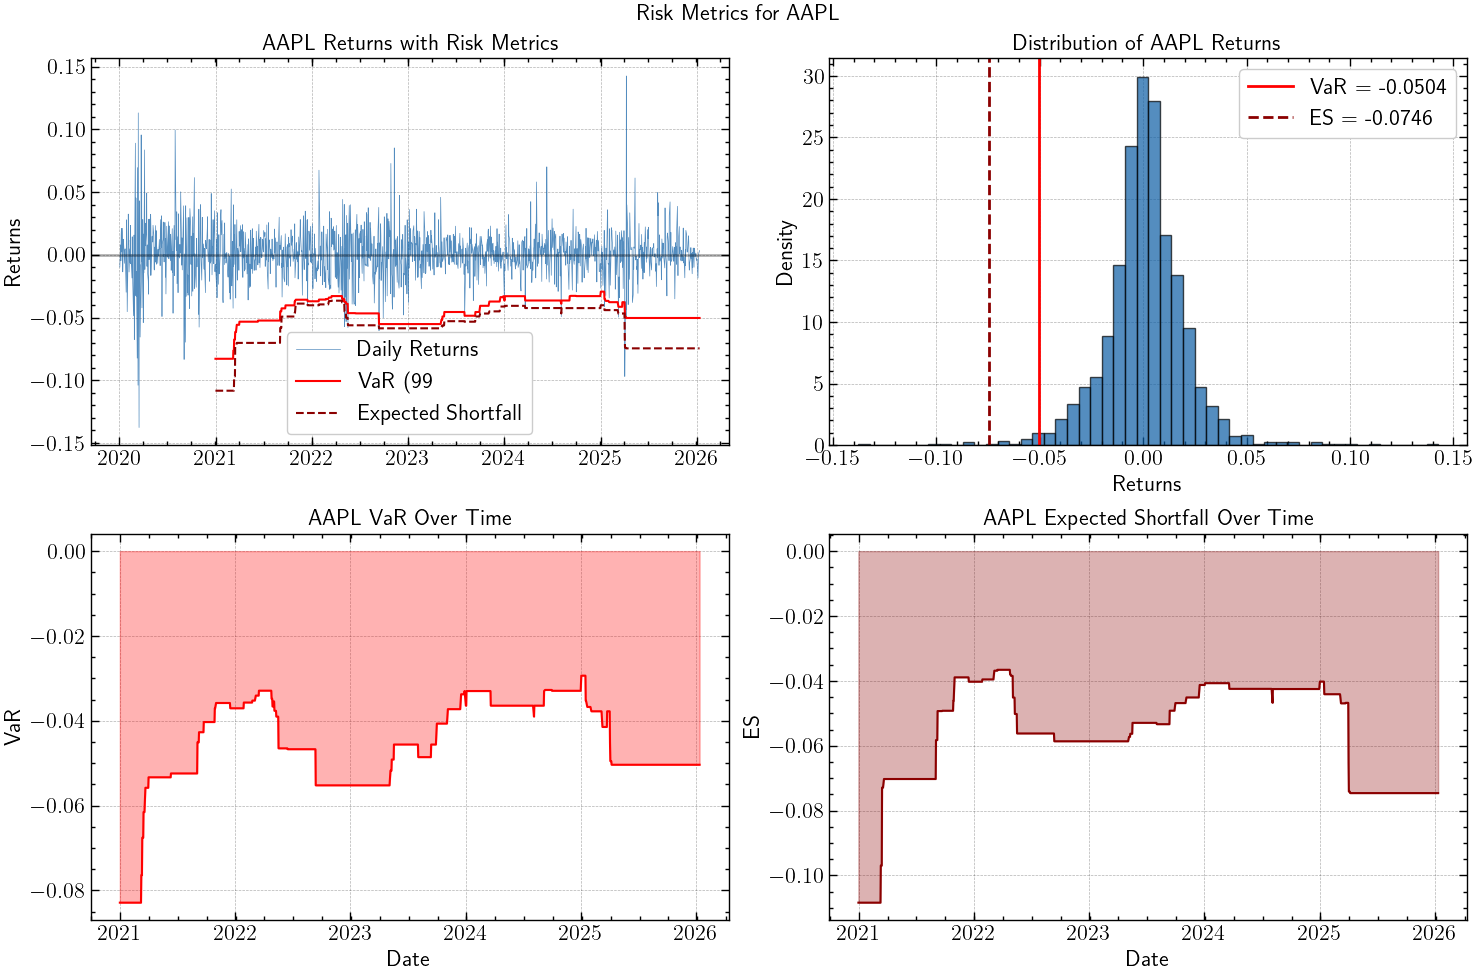

ValueError: 'darkred--' is not a valid format string (unrecognized character 'a')

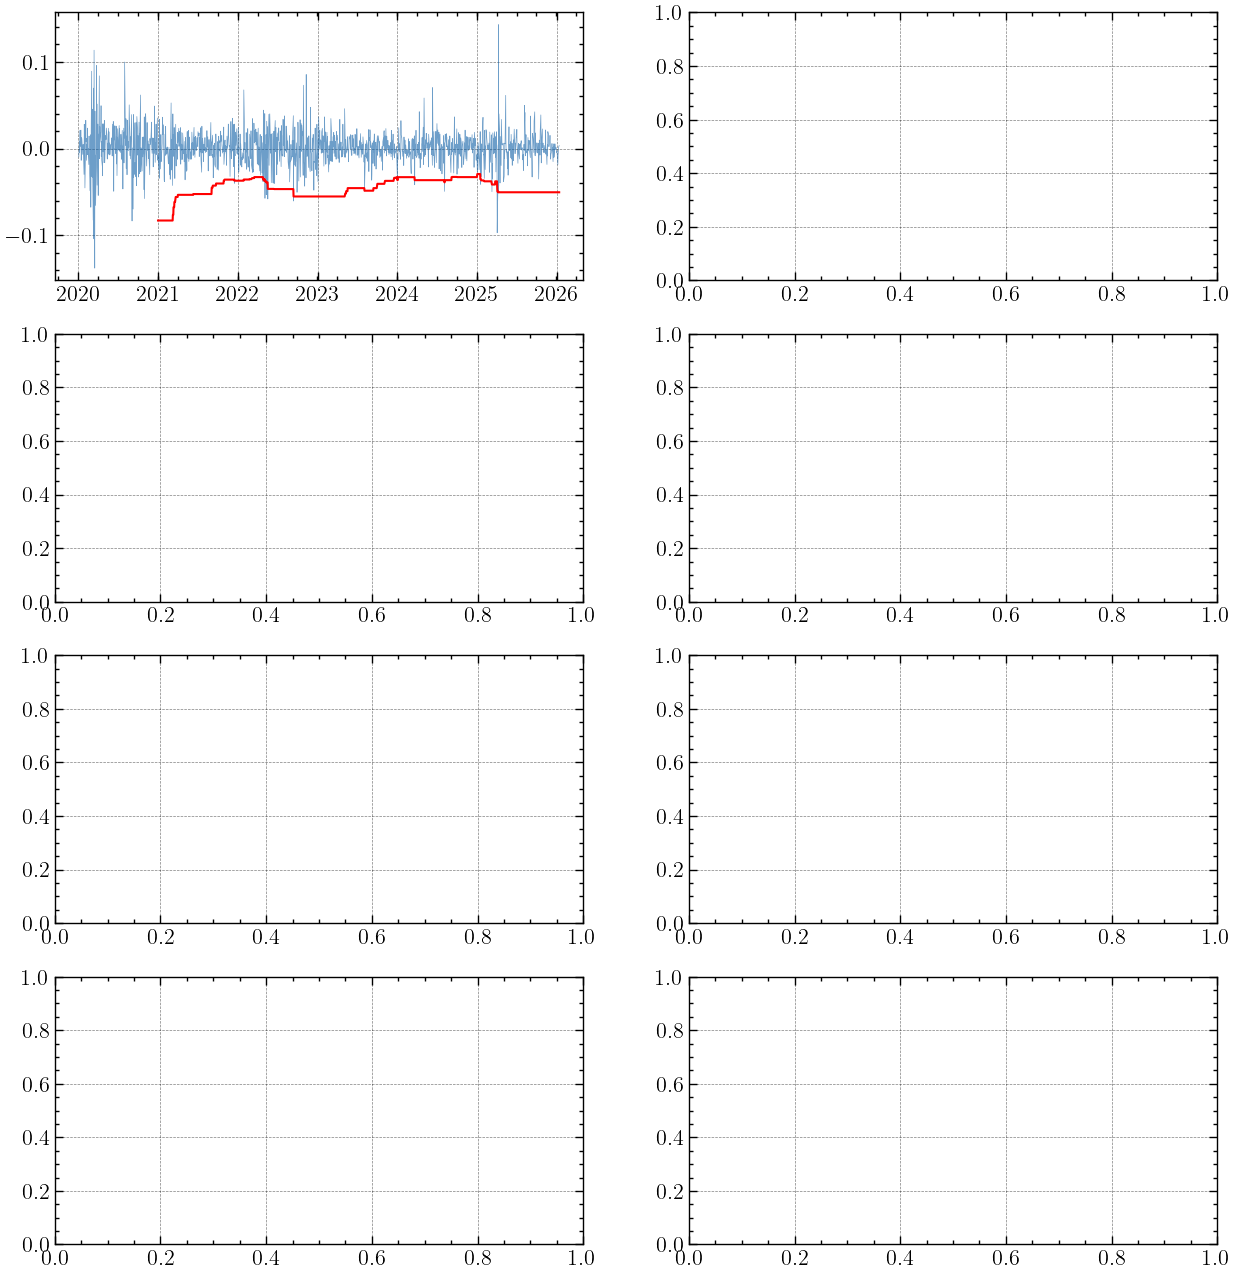

In [29]:
# Initialize the framework
bt = Backtesting_Framework(tickers=['AAPL', 'MSFT', 'GOOGL', 'AMZN'])

# Prepare data
returns = bt.data_preparation()

# Calculate VaR and ES
results = bt.HS_Rolling_VaR_ES()

# Print results
print(results[['Ticker', 'VaR', 'ES']])

# Plot for specific ticker
bt.plot_risk_metrics(ticker='AAPL')

# Plot for all tickers
bt.plot_risk_metrics()

# Plot comparison charts
bt.plot_comparison()